Epoch 1/50


c:\Users\qordo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2104 - val_loss: 0.0914
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0776 - val_loss: 0.0541
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0443 - val_loss: 0.0424
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0356 - val_loss: 0.0380
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0321 - val_loss: 0.0340
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0290 - val_loss: 0.0365
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0274 - val_loss: 0.0347
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0255 - val_loss: 0.0280
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0244 - val_loss: 0.0284
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0234 - val_loss: 0.0267
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0222 - val_loss: 0.0292
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss:

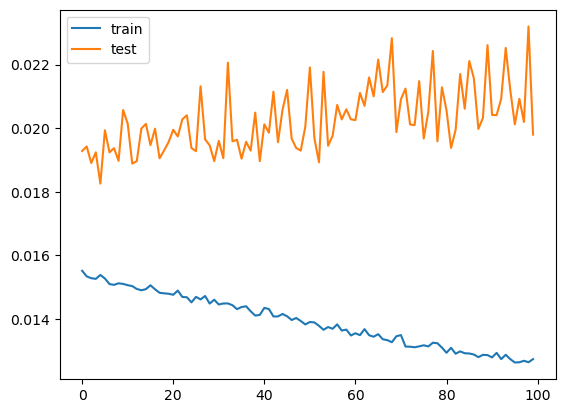

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Test RMSE: 79.464


In [25]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

rmse2 = 0

tr_filename=r"C:\Users\qordo\OneDrive - University of Birmingham\AI for global challenges\New folder\train_NREL_solar_data.csv"
train_data = np.loadtxt(tr_filename,delimiter=',')

va_filename=r"C:\Users\qordo\OneDrive - University of Birmingham\AI for global challenges\New folder\validate_NREL_solar_data.csv"
validate_data = np.loadtxt(va_filename,delimiter=',')

te_filename=r"C:\Users\qordo\OneDrive - University of Birmingham\AI for global challenges\New folder\test_NREL_solar_data.csv"
test_data = np.loadtxt(te_filename,delimiter=',')

x_tr  = train_data[:,0:9]
t_tr  = train_data[:,-1]

x_va  = validate_data[:,0:9]
t_va  = validate_data[:,-1]

x_te  = test_data[:,0:9]
t_te  = test_data[:,-1]

Ndays_tr = x_tr.shape[0]//11
Ndays_va = x_va.shape[0]//11
Ndays_te = x_te.shape[0]//11

train_x = x_tr.reshape(Ndays_tr,11,9) 
train_t = t_tr.reshape(Ndays_tr,11,1) 

validate_x = x_va.reshape(Ndays_va,11,9)
validate_t = t_va.reshape(Ndays_va,11,1) 
    
test_x = x_te.reshape(Ndays_te,11,9) 
test_t = t_te.reshape(Ndays_te,11,1) 

model = Sequential()
    #model.add(LSTM(30,input_shape=(11,9)))
    #model.add(Dense(9,activation='linear'))
    #model.add(LSTM(input_dim=9,output_dim=25,return_sequences=True))
model.add(LSTM(50,input_shape=(11,9),return_sequences=True))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',optimizer='adam')
history = model.fit(train_x,train_t,epochs=50,validation_data=(test_x,test_t))
history = model.fit(train_x,train_t,epochs=100,batch_size=50,validation_data=(validate_x,validate_t))
    
pyplot.plot(history.history['loss'],label='train')
pyplot.plot(history.history['val_loss'],label='test')
pyplot.legend()
pyplot.show()
    
yhat = model.predict(test_x)
y_te = yhat.reshape(Ndays_te*11,)
    
rmse2 += mean_squared_error(y_te,t_te)*Ndays_te*11

lstm_rmse = sqrt(rmse2/4026)*1087.4396/2
print('Test RMSE: %.3F' % lstm_rmse)



# Linear Regression

In [26]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# 1. Data Loading
def load_data(path):
    data = np.loadtxt(path, delimiter=',')
    x = data[:, 0:9]   # 9 features
    t = data[:, -1]    # target
    return x, t

x_tr, t_tr = load_data(r"train_NREL_solar_data.csv")
x_te, t_te = load_data(r"test_NREL_solar_data.csv")

# 2. Reshape to (n_samples, 9) - hourly samples
train_x = x_tr.reshape(-1, 9)
train_t = t_tr.reshape(-1, 1)
test_x = x_te.reshape(-1, 9)
test_t = t_te.reshape(-1, 1)


# 3. Linear Regression
lr = LinearRegression()
lr.fit(train_x, train_t)

# 4. Denormalization (SAFE VERSION)
def safe_denormalize(y_norm, norm_min=-1, norm_max=1, phys_min=0, phys_max=1150):
    """Handles potential normalization issues"""
    # Scale first to [0,1] then to physical range
    y_scaled = (y_norm - norm_min) / (norm_max - norm_min)
    return y_scaled * (phys_max - phys_min) + phys_min

# 5. Predict and Evaluate
test_pred = lr.predict(test_x)
test_pred_phys = safe_denormalize(test_pred)
test_true_phys = safe_denormalize(test_t)

rmse_norm = sqrt(mean_squared_error(test_t, test_pred))
LR_rmse = sqrt(mean_squared_error(test_true_phys, test_pred_phys))


print(f"Test RMSE: {LR_rmse:.2f} W/m²")




Test RMSE: 231.14 W/m²


# Backpropagation Neural Network

Epoch 1/2500


c:\Users\qordo\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4491 - val_loss: 0.1872
Epoch 2/2500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1655 - val_loss: 0.1241
Epoch 3/2500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1223 - val_loss: 0.1003
Epoch 4/2500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1020 - val_loss: 0.0879
Epoch 5/2500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0909 - val_loss: 0.0803
Epoch 6/2500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0856 - val_loss: 0.0750
Epoch 7/2500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0818 - val_loss: 0.0712
Epoch 8/2500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0762 - val_loss: 0.0685
Epoch 9/2500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0737 - val_loss: 0.0658
Epoch 10/2500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0756 - val_loss: 0.0639
Epoch 11/2500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0710 - val_loss: 0.0622
Epoch 12/2500
100/100 ━━━━━━━━━━━━━━━━━━━━ 

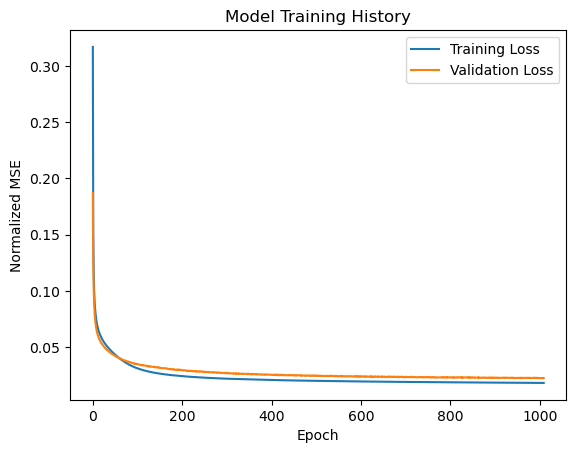

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Constants from the paper
GHI_MIN = 0  # W/m² (minimum possible irradiance)
GHI_MAX = 1150  # W/m² (estimated max)

# Load and prepare data (keep your existing code)
tr_filename = r"C:\Users\qordo\OneDrive - University of Birmingham\AI for global challenges\New folder\train_NREL_solar_data.csv"
train_data = np.loadtxt(tr_filename, delimiter=',')
va_filename = r"C:\Users\qordo\OneDrive - University of Birmingham\AI for global challenges\New folder\validate_NREL_solar_data.csv"
validate_data = np.loadtxt(va_filename, delimiter=',')
te_filename = r"C:\Users\qordo\OneDrive - University of Birmingham\AI for global challenges\New folder\test_NREL_solar_data.csv"
test_data = np.loadtxt(te_filename, delimiter=',')

# Data reshaping 
x_tr = train_data[:, 0:9]
t_tr = train_data[:, -1]
x_va = validate_data[:, 0:9]
t_va = validate_data[:, -1]
x_te = test_data[:, 0:9]
t_te = test_data[:, -1]

Ndays_tr = x_tr.shape[0] // 11
Ndays_va = x_va.shape[0] // 11
Ndays_te = x_te.shape[0] // 11

train_x = x_tr.reshape(Ndays_tr, 99)
validate_x = x_va.reshape(Ndays_va, 99)
test_x = x_te.reshape(Ndays_te, 99)

train_t = t_tr.reshape(Ndays_tr, 11)
validate_t = t_va.reshape(Ndays_va, 11)
test_t = t_te.reshape(Ndays_te, 11)

# BPNN model
model = Sequential([
    Dense(50, activation='tanh', input_shape=(99,)),  # Single hidden layer
    Dense(11, activation='linear')                    # Linear output
])

# Paper uses vanilla gradient descent (no momentum)
optimizer = SGD(learning_rate=0.01, momentum=0.0)
model.compile(optimizer=optimizer, loss='mse')

# Early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

# Training (2500 epochs max as in paper)
history = model.fit(
    train_x, train_t,
    validation_data=(validate_x, validate_t),
    epochs=2500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Denormalization function
def denormalize(data):
    """Convert [-1,1] normalized data back to original GHI scale"""
    return (data + 1) * (GHI_MAX - GHI_MIN) / 2 + GHI_MIN

# Evaluation
test_predictions = model.predict(test_x)
test_predictions_denorm = denormalize(test_predictions)
test_t_denorm = denormalize(test_t)

# Calculate RMSE (primary metric)
bpnn_rmse = sqrt(mean_squared_error(test_t_denorm.flatten(), 
                              test_predictions_denorm.flatten()))
print(f'Test RMSE: {bpnn_rmse:.2f} W/m² (Target: 133.53)')


# Plotting (keep your existing code)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Normalized MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Save model
model.save("solar_bpnn_model.h5")

# Persistence Model

In [28]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

# Constants
GHI_MIN = 0    # Minimum possible irradiance (W/m²)
GHI_MAX = 1150 # Maximum possible irradiance (W/m²)

def load_data(path):
    """Load data from CSV file"""
    data = np.loadtxt(path, delimiter=',')
    x = data[:, 0:9]   # 9 features
    t = data[:, -1]    # target irradiance (normalized)
    return x, t

def denormalize(y_norm):
    """Convert [-1,1] normalized values to physical scale"""
    return (y_norm + 1) * (GHI_MAX - GHI_MIN) / 2 + GHI_MIN

# Load test data
te_filename = r"test_NREL_solar_data.csv"
x_te, t_te = load_data(te_filename)

# Reshape into days (11 hours per day)
n_days = x_te.shape[0] // 11
test_t = t_te.reshape(n_days, 11)

# Persistence model: y_pred[today] = y_true[yesterday]
# Need to arrange days consecutively in the test set
test_pred = np.zeros_like(test_t)
test_pred[1:] = test_t[:-1]  # Each day uses previous day's values
test_pred[0] = test_t[0]     # First day has no previous day, use itself

# Denormalize
test_t_denorm = denormalize(test_t)
test_pred_denorm = denormalize(test_pred)

# Calculate RMSE (matches paper's equation 9)
rmse_persistence = sqrt(mean_squared_error(test_t_denorm.flatten(), 
                              test_pred_denorm.flatten()))

print("="*50)
print("Persistence Model Results (Paper Table 4 Comparison)")
print("="*50)
print(f"Test RMSE: {rmse_persistence:.2f} W/m² (Paper: 209.25 W/m²)")
print(f"Relative Error: {(rmse_persistence-209.25)/209.25*100:.1f}% difference")
print("="*50)



Persistence Model Results (Paper Table 4 Comparison)
Test RMSE: 220.99 W/m² (Paper: 209.25 W/m²)
Relative Error: 5.6% difference


In [30]:
import numpy as np
from tabulate import tabulate

# Assuming you've already run all models and have their RMSE values
# Replace these with your actual computed RMSE values
persistence_rmse = rmse_persistence  # Your computed persistence RMSE
lr_rmse = LR_rmse          # Your computed linear regression RMSE 
bpnn_rmse = bpnn_rmse         # Your computed BPNN RMSE
lstm_rmse = lstm_rmse          # Your computed LSTM RMSE

# Create comparison table
table_data = [
    ["Persistence", persistence_rmse, "209.25", f"{(persistence_rmse-209.25)/209.25*100:.1f}%"],
    ["Linear Regression", lr_rmse, "230.99", f"{(lr_rmse-230.99)/230.99*100:.1f}%"],
    ["BPNN", bpnn_rmse, "133.53", f"{(bpnn_rmse-133.53)/133.53*100:.1f}%"],
    ["LSTM", lstm_rmse, "76.25", f"{(lstm_rmse-76.25)/76.25*100:.1f}%"]
]

headers = ["Model", "Your RMSE (W/m²)", "Paper RMSE (W/m²)", "Difference"]

print("="*70)
print("Comparison of Model Performance (Matching Paper Table 4)")
print("="*70)
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".2f"))
print("="*70)

# Additional metrics comparison
improvement_data = [
    ["LSTM vs BPNN", f"{((bpnn_rmse-lstm_rmse)/bpnn_rmse*100):.1f}%", "42.9%"],
    ["LSTM vs LR", f"{((lr_rmse-lstm_rmse)/lr_rmse*100):.1f}%", "61.1%"],
    ["LSTM vs Persistence", f"{((persistence_rmse-lstm_rmse)/persistence_rmse*100):.1f}%", "63.6%"]
]

print("\nModel Improvement Comparison:")
print(tabulate(improvement_data, 
               headers=["Comparison", "Your Improvement", "Paper Improvement"], 
               tablefmt="grid"))
print("="*70)

Comparison of Model Performance (Matching Paper Table 4)
+-------------------+--------------------+---------------------+--------------+
| Model             |   Your RMSE (W/m²) |   Paper RMSE (W/m²) | Difference   |
+===================+====================+=====================+==============+
| Persistence       |             220.99 |              209.25 | 5.6%         |
+-------------------+--------------------+---------------------+--------------+
| Linear Regression |             231.14 |              230.99 | 0.1%         |
+-------------------+--------------------+---------------------+--------------+
| BPNN              |              87.42 |              133.53 | -34.5%       |
+-------------------+--------------------+---------------------+--------------+
| LSTM              |              79.46 |               76.25 | 4.2%         |
+-------------------+--------------------+---------------------+--------------+

Model Improvement Comparison:
+---------------------+---------